# ENN583: Week 11 Practical
## Using GG-CNN to generate grasps!

We will be working with the public implementation of GG-CNN which is available at this [link](https://github.com/dougsm/ggcnn).

In particular, we're going to explore how you can:
* load in the Project 2 data
* adapt the data into the correct format for GG-CNN
* test the data through GG-CNN to generate a rectangle grasp
* evaluate whether the grasp is a 'True Positive' or not, to calculate Grasp detection rate 

In [1]:
!pip install shapely 

import torch
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage

import matplotlib.patches as patches
import math

from shapely.geometry import Polygon

## Make sure you have the correct Project 2 data.

Open the Project_2/download_data.ipynb and re-run the script to download the Project 2 data. This was changed on Thursday of Week 11 to use better depth data for grasp prediction.

## Loading in the Grasp prompts

As is mentioned on the Project 2 instructions page on canvas, there is a 'validation_prompts.json' which contains a series of requested tests for you to perform. Each test contains a file name for an image in the dataset and a text prompt for the object that should be grasped. 

Below, let's load in the file and inspect some examples of the tests.

In [2]:
with open('../Project_2/validation_prompts.json', 'r') as f:
    data = json.load(f)

print(f'There are {len(data.keys())} tests')
print('Here are the first 5 tests:')
for i, test_name in enumerate(data.keys()):
    print(f'{test_name}: {data[test_name]}')
    if i >= 4:
        break

There are 604 tests
Here are the first 5 tests:
test_1: ['Graspnet_subset/validation_scenes/scene_0050/rgb/0000.png', 'banana']
test_2: ['Graspnet_subset/validation_scenes/scene_0050/rgb/0000.png', 'knife']
test_3: ['Graspnet_subset/validation_scenes/scene_0050/rgb/0012.png', 'computer mouse']
test_4: ['Graspnet_subset/validation_scenes/scene_0050/rgb/0017.png', 'mug']
test_5: ['Graspnet_subset/validation_scenes/scene_0050/rgb/0021.png', 'mug']


### Test_1 - grasp the banana
For most of this practical, we're going to focus on test_1. It will then be your job to connect this code with the object detection code, and automate testing over the many different files.

As you can see above, test_1 is trying to grasp a banana in the image Graspnet_subset/validation_scenes/scene_0050/rgb/0000.png.

Let's first load in and visualise the RGB and depth version of this image.

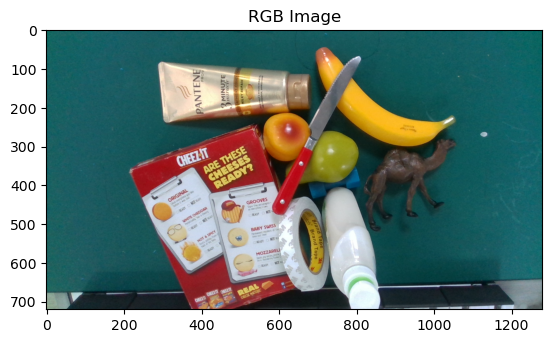

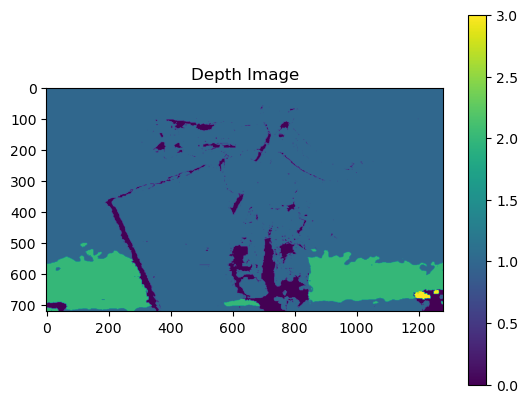

In [3]:
im_name = data['test_1'][0]
rgb_name = f'../Project_2/{im_name}'
depth_name = rgb_name.replace('rgb', 'depth')


im_rgb = cv2.imread(rgb_name)
im_rgb = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB)
im_depth = cv2.imread(depth_name,cv2.IMREAD_GRAYSCALE)


plt.imshow(im_rgb)
plt.title('RGB Image')
plt.show()

plt.imshow(im_depth)
plt.colorbar()
plt.title('Depth Image')
plt.show()

### Adapting the data for GG-CNN

GG-CNN wants to test on images of size 300 pixels by 300 pixels. It also works best when cropped around an object. 

To do this, we should:
1. Crop the image to a patch that captures the object (i.e. banana). This crop should be AT MINIMUM 300x300.
2. Then resize the crop to 300x300.

Looking at the RGB image above, adapt the code below to crop the image around the object we want to grasp - the banana - and then the crop will be resized. You can use the code below to check how well you have cropped around the banana.

**Consider: Here we are manually cropping around the banana... how could you leverage an object detector to do this automatically?**

In [ ]:
#Adapt the code below to crop around the banana!
x_offset = 0
y_offset = 0
crop_width = im_rgb.shape[1]
crop_height = im_rgb.shape[0]

crop_rgb = im_rgb[y_offset:y_offset+crop_height, x_offset:x_offset+crop_width]
crop_depth = im_depth[y_offset:y_offset+crop_height, x_offset:x_offset+crop_width]

#resize to always be 300x300
crop_rgb = cv2.resize(crop_rgb, (300, 300))
crop_depth = cv2.resize(crop_depth, (300, 300))

plt.imshow(crop_rgb)
plt.title('RGB Crop')
plt.show()

plt.imshow(crop_depth)
plt.colorbar()
plt.title('Depth Crop')
plt.show()

After a crop has been created and re-sized, GG-CNN also does some checks on the depth image to make sure it is in suitable format for the model. This code has nicely been formatted in a function for you. Read the code below to understand what is happening, and then try passing in the crop_depth and visualising the output.

In [ ]:
def clean_depth_image(depth_im, out_size = 300):
    #add a border of a single pixel to the depth image
    depth_crop = cv2.copyMakeBorder(depth_im, 1, 1, 1, 1, cv2.BORDER_DEFAULT)

    #check for any nan values -- slightly dilate so not too noisy
    depth_nan_mask = np.isnan(depth_crop).astype(np.uint8)
    kernel = np.ones((3, 3),np.uint8)
    depth_nan_mask = cv2.dilate(depth_nan_mask, kernel, iterations=1)

    #any nan are set to have a value of 0 for now
    depth_crop[depth_nan_mask==1] = 0

    # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
    depth_scale = np.abs(depth_crop).max()
    depth_crop = depth_crop.astype(np.float32) / depth_scale  # Has to be float32, 64 not supported.

    #all previous nan values are in-painted 
    depth_crop = cv2.inpaint(depth_crop, depth_nan_mask, 1, cv2.INPAINT_NS)

    # Back to original size and value range (m from camera) -- essentially remove border and re-scale
    depth_crop = depth_crop[1:-1, 1:-1]
    depth_crop = depth_crop * depth_scale
    
    # Resize
    depth_crop = cv2.resize(depth_crop, (out_size, out_size), cv2.INTER_AREA)

    return depth_crop

#Call the clean_depth_image function on the crop_depth and visualise the output -- has it changed?

We are almost ready to test the data! The last thing we need to do is format it for a Pytorch model by:
1. Centering the values around 0 by subtracting the mean (i.e. pseudo-normalizing depth values)
2. Converting the depth crop to a Tensor and moving it to the GPU

In [ ]:
# Prepare for torch models -- center the depth around 0
depth_norm = np.clip((crop_depth - crop_depth.mean()), -1, 1)

#convert to tensor and move to GPU
#reshaping to be batch x channels x width x height
depth_tensor = torch.from_numpy(depth_norm.reshape(1, 1, 300, 300).astype(np.float32)).cuda()
    

### Test the data through GG-CNN to generate a rectangle grasp!

Below, we are loading in the GG-CNN model and passing our depth image through to get an output! 

Have a close look at the output -- there are a number of segmentation maps for the quality of each pixel for grasping, the angle for grasping, and the width of the grasp.

Adapt the cell below to visualise these segmentation maps.

In [ ]:

model = torch.load('ggcnn2_weights_cornell/epoch_50_cornell')

with torch.no_grad():
    quality, cos, sin, width = model(depth_tensor)

quality = quality.cpu().numpy()
cos = cos.cpu().numpy()
sin = sin.cpu().numpy()
width = width.cpu().numpy()

ang_radians = np.arctan2(sin, cos) / 2.0

#Use plt.imshow() to visualise the results of the segmentation outputs. You may want to do this alongside showing the crop_rgb to help interpret.

You might notice a couple of things that don't make a lot of sense in the above:
1. There are some weird noisy patches and artifacts -- it's not very smooth!
2. We want to know the width of the gripper in pixels, but the values do not go very high.

This is because there is actually some post-processing that needs to happen! Read the function below to see the post-processing that should be done, and then re-visualise each of the grasp maps.

Each of the postprocessing steps are recommended by the authors of the GG-CNN paper -- ask yourself, do they make sense? Why would they be beneficial?

In [ ]:
def postprocess_segmentations(quality_seg, angle_seg, width_seg):
    filters = (2, 2, 1)

    #width is scaled by 150 pixels
    width_seg = width_seg * 150.0

    #apply a smoothing filter to each of the segmentation masks
    if filters[0]:
        quality_seg = ndimage.filters.gaussian_filter(quality_seg, filters[0]) 
    if filters[1]:
        angle_seg = ndimage.filters.gaussian_filter(angle_seg, filters[1])
    if filters[2]:
        width_seg = ndimage.filters.gaussian_filter(width_seg, filters[2])

    #clip the quality segmentation mask to between 1 and 0.999
    quality_seg = np.clip(quality_seg, 0, 1.0-1e-3)

    return quality_seg, angle_seg, width_seg


#pass in the outputs to the above function and then visualise the postprocessed results.
quality_final, ang_radians_final, width_final = ....


Now, we can extract a grasp in terms of a center x, center y, gripper width, and angle from our segmentation masks. 

Below, let's first check where the most confident grasp predictions are based on the quality segmentation!

In [ ]:
def get_rotated_rectangle_corners(center_x, center_y, width, angle_rad):
    # Given a grasp prediction in the format required by the assignment, this function will convert it into 
    # 4 rotated rectangle corners that can be drawn onto an image and visualised. Or compared with a GT grasp
    # for performance evaluation.
    
    #height is fixed based on the gripper 
    height = 30
    
    # Extract center coordinates
    cx, cy = center_x, center_y

    # Calculate half dimensions
    half_width = width / 2
    half_height = height / 2
    
    # Calculate the original corner positions relative to the center
    corners = [
        (-half_width, -half_height),  # Bottom-left
        (half_width, -half_height),   # Bottom-right
        (half_width, half_height),    # Top-right
        (-half_width, half_height)    # Top-left
    ]
    
    # Apply rotation and translation to each corner
    rotated_corners = []
    for x, y in corners:
        # Calculate rotated positions
        rotated_x = cx + (x * math.cos(angle_rad)) - (y * math.sin(angle_rad))
        rotated_y = cy + (x * math.sin(angle_rad)) + (y * math.cos(angle_rad))
        rotated_corners.append((rotated_x, rotated_y))
    
    return rotated_corners

In [ ]:
quality_final = quality_final.squeeze()
width_final = width_final.squeeze()
ang_radians_final = ang_radians_final.squeeze()

most_confident_pixels = np.dstack(np.unravel_index(np.argsort(quality_final.ravel())[::-1], quality_final.shape))[0]
#print the 10 most confident pixels
print(most_confident_pixels[:10])

plt.imshow(quality_final)
plt.colorbar()
plt.title('Postprocessed Quality')
plt.show()

The code below will take **the most confident** grasp as the prediction, drawing the rotated rectangle.

**Consider: You want to grab the grasp for a specific object -- how could you do this using your results from your object detector?**

Adapt the code below to try and only take a grasp that is on a banana. You can hand-code this at first but make sure to think how you would do it automatically.

In [ ]:
max_pixel = most_confident_order[0]
u = max_pixel[1]
v = max_pixel[0]
ang = ang_radians_final[max_pixel[0], max_pixel[1]]
width = width_final[max_pixel[0], max_pixel[1]]

#convert to grasp rectangle
grasp_rect = get_rotated_rectangle_corners(u, v, width, ang)

#Plot the image with the grasp
fig, ax = plt.subplots()
ax.imshow(crop_rgb)
polygon = patches.Polygon(grasp_rect, closed=True, edgecolor='red', linewidth=2, fill=None)
ax.add_patch(polygon)
plt.show()

Now we have the grasp in terms of our image crop -- but for evaluation, we need to convert it back into the global image coordinates! Use the code below to do that.

**Note: this relies on knowing the crop_width, crop_height and x,y offsets from when we cropped and resized.**

In [ ]:
delta_w = crop_width/300
delta_h = crop_height/300

# Convert max_pixel back to uncropped/resized image coordinates.
u = u*delta_w + x_offset
v = v*delta_h + y_offset
width = width*delta_w

#convert to grasp rectangle
grasp_rect = get_rotated_rectangle_corners(u, v, width, ang)

#Plot the image with the grasp
fig, ax = plt.subplots()
ax.imshow(im_rgb)
polygon = patches.Polygon(grasp_rect, closed=True, edgecolor='red', linewidth=2, fill=None)
ax.add_patch(polygon)
plt.show()


## Evaluate whether the grasp is a 'True Positive' or not

Let's load in all the GT grasp labels.

In [4]:
#read in gt grasp labels
with open('../Project_2/validation_grasp_labels.json', 'r') as f:
    gt_grasps = json.load(f)

test_1_grasp = gt_grasps['test_1']

For a grasp to be a True Positive, it needs to both:
1. Have an IoU > 0.25 with a GT grasp rectangle, AND
2. Have a grasp angle within 20deg (0.349 radians) of the GT grasp angle.

The code below is testing this condition for the first grasp label in test_1_grasp.

Adapt the code to check over all grasps in test_1_grasp and see if the grasp is a True Positive or False Positive. **It only needs to meet the conditions with a single GT grasp to be a TP.**

In [ ]:
gt_grasp = test_1_grasp[0]
gt_angle = -np.arctan((g[0][0] - g[3][0]) / (g[0][1] - g[3][1])) #use this to calculate angle of rotation of rectangle

#Calculate IoU
polygon1 = Polygon(grasp_rect)
polygon2 = Polygon(gt_grasp)
intersect = polygon1.intersection(polygon2).area
union = polygon1.union(polygon2).area
iou = intersect / union

if iou > 0.25:
    if np.abs(gt_angle - angle) < 0.349:
        print('TP')
    else:
        print('FP')
else:
    print('FP')